ChatGPTが大バズリしている昨今です。僕はプロンプトを考えるのが面倒なので（ええ...)あまり使わないのですが、友人が論文を書くのに使っていたり、僕の母親が話し相手に使っていたり（ええ...）するようです。そんな中僕はいまだにTransformerが何なのかすらよくわかっていなかったので、とりあえず何をやっているのかくらいは理解してみようとしてみます。

# 参考にしたもの
- [Formal Algorithms for Transformers](https://arxiv.org/abs/2207.09238)
  - 疑似コードをまとめた論文です。これが一番わかりやすいと思うので、とりあえずこれを見ればいいと思います。他にも[The Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/)などを見たのですが、よくわかりませんでした。
- [Shumi-Note Transformer](https://github.com/syuntoku14/Shumi-Note/blob/main/notebooks/NN_transformer.ipynb)
  - これを見て真似しようと思ったのがこの記事のきっかけです。

# トークン列のエンコーディング
Transformerでは、入力されたトークン列に対し、multihead attentionと呼ばれるレイヤーを繰り返し適用します。そこで、まずどのようにトークン列をベクトルに射影するのかを説明します。

## 最初に列があった
トークン列というのは文字通りトークンからなる列のことです。トークンは有限集合の要素です。実用上はbyte pair encodingにより得られたsubwordなどがこれに該当しますが、とりあえず気にしなくていいです。トークンの集合を$V$とし、$[Nv] := {1, ..., Nv}$と番号付けしておきます。トークン列を$x = x[1: l]$と書きます。また、トークン列の最大の長さを$L$とします。トークンとして連続値や無限集合は扱えないと思いますが、素人なので何か抜け道があるかどうかは知りません。

## トークンからベクトルに
適当な$d_e \times Nv$次元の行列$W_e$を使って、$v$番目のトークンから埋め込み（Token embedding）を $e = W_e[:, v]$により得ます。これは$d_e$次元のベクトルになります。なお、numpy風に$i$番目の行ベクトルを$W[i, :]$、$j$番目の列ベクトルを$W[:, j]$と書いています。この行列$W_e$は勾配降下により学習されるようです。

## ついでに位置もベクトルに
適当な$d_p \times L$次元の行列$W_p$を使って、トークン列中の$l$番目にトークンがあるという情報から、位置埋め込み（Positional embedding）を $p = W_p[:, l]$により得ます。これも$d_e$次元のベクトルになります。正直なんの意味があるのかよくわからないのですが、これを先程のトークン埋め込みに足してトークン列$x$の$t$番目のトークン$x[t]$に対する埋め込みを$e = W_e[:, x[t]] + W_p[:, t]$によって得ます。これ足して大丈夫なのかな？って思うんですが。
位置埋め込みは、学習されることもあるようですが、Transformerが最初に提案された[Attention Is All You Need](https://arxiv.org/abs/1706.03762)の論文では、以下のように構成されています。
$$
\begin{align*}
W_p[2i - 1, t] &= \sin (\frac{t}{L^{2i / d_e}}) \\
W_p[2i, t] &= \cos (\frac{t}{L^{2i / d_e}}) \\
&~~~~~(0 < 2i \leq d_e)
\end{align*}
$$
これを$L=50, d_e = 5$として可視化してみましょう。

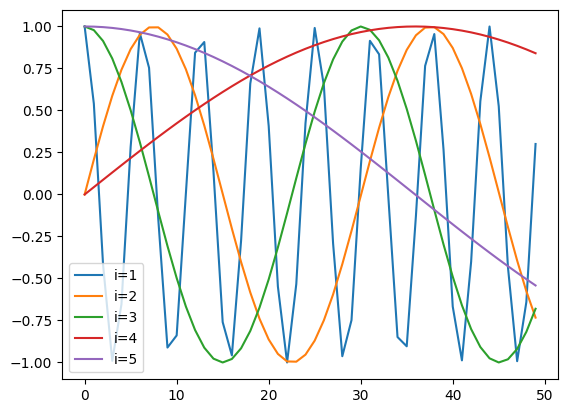

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

L = 50
d_e = 5
x = np.arange(L)
for i in range(1, 1 + d_e):
    if i % 2 == 0:
        w_p = np.sin(x / L ** (i / d_e))
    else:
        w_p = np.cos(x / L ** ((i - 1) / d_e)) 
    _ = plt.plot(x, w_p, label=f"i={i}")
plt.legend()

というわけで、この埋めこみは各成分ごとに異なる周波数での単語を埋め込むようです。これにより、短いコンテキストの中での位置も同時に考慮できるのかな。

# Attention
Transformerの主要な構成要素になるのがAttentionです。同様に系列を扱えるネットワークとしてCNNやRNNがあります。CNNが現在のトークン$x[t]$の近くのトークンだけを見る、RNNが現在のトークンと過去のトークンだけを見るのに対し、Attentionでは$x$中のすべてのトークンについて、現在のトークンとの関係を直接モデル化します。これにより、CNNは何層も重ねないと長期的な依存関係が見れないのですが、Attentionでは一つのレイヤーでトークン列の中の長期的な依存関係を見ることができます。具体的に、現在のトークンから得た埋め込み$e$と$x$中のすべてのトークンの埋め込み$e_0, e_1, ..., e_{Nv} \in E$に対し、以下のような操作を行います。
$$
\begin{align*}
q &\leftarrow W_q e + b_q \\
k_t &\leftarrow W_k e_t + b_k,~\forall e_t \in E \\
v_t &\leftarrow W_v e_t + b_v,~\forall e_t \in E \\
\alpha_t &\leftarrow \frac{\exp(q^\top k_t / \sqrt{d_{\textrm{attn}}})}{\sum_u \exp(q^\top k_u / \sqrt{d_{\textrm{attn}}})},~\forall e_t \in E \\
v_\textrm{attr} &\leftarrow \sum_{t = 1}^T \alpha_t v_t
\end{align*}
$$
$W_*$は$d_\textrm{attn} \times e$の次元の行列、$b_*$はベクトル（バイアス項）です。ここで、$q^\top k_t$の値でソフトマックスをとって$v$にマスクをかけるので、これは現在のトークンと$t$番目のトークンが「どれくらい対応しているか」を表していてほしいです。$v_t$が何を表しているかはタスクによって異なると思いますが、何か$t$番目のトークンの埋め込みに線形に関係する値が入っているはずです。

実際のTransoformerはもっと複雑ですが、とりあえずこれを学習させてみましょう。今回は[jax](https://jax.readthedocs.io/en/latest/)と[quinox](https://docs.kidger.site/equinox/)を使ってモデルを書いてみます。

In [ ]:
import equinox as eqx
import jax
import jax.numpy as jnp


class SingleQueryAttention(eqx.Module):
    w_q: jax.Array
    b_q: jax.Array
    w_k: jax.Array
    b_k: jax.Array
    w_v: jax.Array
    b_v: jax.Array
    sqrt_d_attn: jax.Array

    def __init__(self, d_in: int, d_attn: int, key: jax.Array) -> None:
        wq_key, bq_key, wk_key, bk_key, wv_key, bv_key = jax.random.split(key, 6)
        self.w_q = jax.random.normal(wq_key, (d_attn, d_in))
        self.b_q = jax.random.normal(bq_key, (d_attn, 1))
        self.w_k = jax.random.normal(wk_key, (d_attn, d_in))
        self.b_k = jax.random.normal(bk_key, (d_attn, 1))
        self.w_k = jax.random.normal(wv_key, (d_attn, d_in))
        self.b_k = jax.random.normal(bv_key, (d_attn, 1))
        self.d_attn = jnp.sqrt(d_attn)

    def __call__(self, e: jax.Array) -> jax.Array:
        q = self.w_q @ e + self.b_q
        k = self.w_k @ e + self.b_k
        v = self.w_v @ e + self.b_v
        alpha = jax.nn.softmax(q.T @ k / self.sqrt_d_attn)
        return alpha @ v.T

これを学習させてみましょう。トークンとして、天気🌧️・☁️・☀️を考えます。この3つの記号に対し適当な埋め込みを与えて、次の日の天気を学習させてみます。よくわからないので、ダブらないようにトークン埋め込みを$[-1, 0, 1]$、位置埋め込みを$1 / t$としてみましょう。最大文字列長は適当に10にします。

In [13]:
TOKEN_EMBEDDING = {
    "🌧️": -1.0,
    "☁️": 0.0,
    "☀️": 1.0,
}

def get_embedding(seq: str, max_seq_len: int | None = None) -> np.ndarray:
    if max_seq_len is None:
        max_seq_len = len(seq)
    e = np.zeros(len(seq) // 2)
    for i in range(len(seq) // 2):
        x = seq[i * 2: i * 2 + 2]
        e[i] = TOKEN_EMBEDDING[x] + (i + 1) / max_seq_len
    return e

まず適当なモデルで天気を生成してみます。🌧️・☁️・☀️がマルチバイト文字であることに注意して、以下のように実装します。

In [11]:
import dataclasses

_GEN = np.random.Generator(np.random.PCG64(11111))
_MARKOV = {
    "": [0.3, 0.4, 0.3],
    "🌧️": [0.6, 0.3, 0.1],
    "☁️": [0.3, 0.4, 0.3],
    "☀️": [0.2, 0.3, 0.5],
}
_MARKOV2 = {
    "": [0.3, 0.4, 0.3],
    "🌧️": [0.6, 0.3, 0.1],
    "☁️": [0.3, 0.4, 0.3],
    "☀️": [0.2, 0.3, 0.5],
}
WEATHERS = ["🌧️", "☁️", "☀️"]


def markov(prev: str) -> str:
    prob = _MARKOV[prev[-2:]]
    return prev + _GEN.choice(WEATHERS, p=prob)


def apply_n(f, init, n: int):
    value = init
    for _ in range(n):
        value = f(value)
    return value


@dataclasses.dataclass
class Dataset:
    weathers: list[str]
    embeddings: list[jax.Array]
    next_weahters: list[str]

    def __getitem__(self, idx):
        return self.__class__(
            weathers=self.weathers[idx],
            embeddings=self.embeddings[idx],
            next_weahters=self.next_weahters[idx],
        )


def make_dataset(f, seq_len, size) -> Dataset:
    w_list, e_list, nw_list = [], [], []
    for _ in range(size):
        weathers = apply_n(f, "", seq_len + 1)
        e = jnp.array(get_embedding(weathers[:-2]))
        w_list.append(weathers)
        e_list.append(e)
        nw_list.append(weathers[-2:])
    return Dataset(w_list, e_list, nw_list)


apply_n(markov, "", 20)

'☁️🌧️🌧️🌧️🌧️🌧️🌧️☁️☀️🌧️🌧️🌧️☁️☁️☁️☀️☁️🌧️☁️☀️'

こんな感じです。いま、次の日の天気だけ予測したいので、モデルの出力は集合{🌧️・☁️・☀️}上での確率分布が適切でしょう。先ほど定義した`SingleQueryAttention`は、長さ$T$の埋め込み列に対して長さ$T \times d_\textrm{attn}$の行列をかえします。なので、この出力を長さ3のベクトルに変換する層をつけたしましょう。

In [ ]:
class PredictTommorowWeather(eqx.Module):
    sqa: SingleQueryAttention
    predict_w: jax.Array
    predict_w: jax.Array

    def __init__(self, d_in: int, d_attn: int, d_pred: jax.Array, key: jax.Array) -> None:
        sqa_key, w_key, b_key = jax.random.split(key, 3)
        self.sqa = SingleQueryAttention(d_in, d_attn, sqa_key)
        

    def __call__(self, e: jax.Array) -> jax.Array:
        q = self.w_q @ e + self.b_q
        k = self.w_k @ e + self.b_k
        v = self.w_v @ e + self.b_v
        alpha = jax.nn.softmax(q.T @ k / self.sqrt_d_attn)
        return alpha @ v.T

In [4]:



@jax.jit
@jax.grad
def loss_fn(model: eqx.Module, seq: jax.Array, next_w: jax.Array) -> jax.Array:
    predicted = jax.vmap(model)(seq)
    return jax.numpy.mean((y - pred_y) ** 2)